Import the libraries especially torchvision

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


## Transformations:

Transformations to the dataset and import it for use.

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /kaggle/input/garbage-classification/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

Helper function to see the image and its corresponding label:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


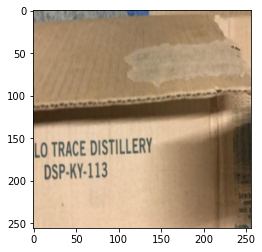

In [5]:
img, label = dataset[12]
show_sample(img, label)

Label: cardboard (Class No: 0)


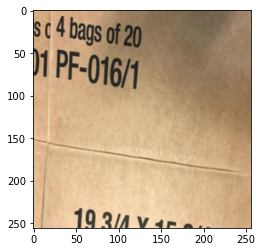

In [6]:
img, label = dataset[7]
show_sample(img, label)

Label: cardboard (Class No: 0)


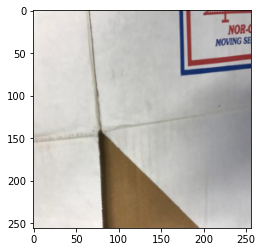

In [7]:
img, label = dataset[2]
show_sample(img, label)

# Loading and Splitting Data:

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

training and validation dataloaders using `DataLoader`.

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

visualize batches:

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

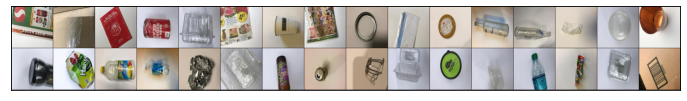

In [13]:
show_batch(train_dl)

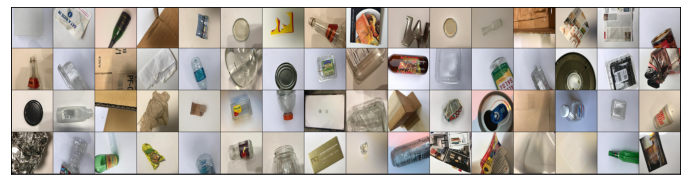

In [14]:
show_batch(val_dl)

# Model Base:

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

ResNet50 for classifying images:

In [16]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
    
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Using GPU for computation

In [17]:
def get_default_device():
    
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(ResNet(), device)

In [22]:
evaluate(model, val_dl)

{'val_loss': 1.7818750143051147, 'val_acc': 0.265625}

In [23]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4614, val_loss: 1.2682, val_acc: 0.8281
Epoch 2: train_loss: 1.1807, val_loss: 1.1530, val_acc: 0.9462
Epoch 3: train_loss: 1.0986, val_loss: 1.1276, val_acc: 0.9479
Epoch 4: train_loss: 1.0729, val_loss: 1.1208, val_acc: 0.9549
Epoch 5: train_loss: 1.0640, val_loss: 1.1340, val_acc: 0.9097
Epoch 6: train_loss: 1.0597, val_loss: 1.1039, val_acc: 0.9514
Epoch 7: train_loss: 1.0549, val_loss: 1.1030, val_acc: 0.9462
Epoch 8: train_loss: 1.0563, val_loss: 1.1097, val_acc: 0.9479


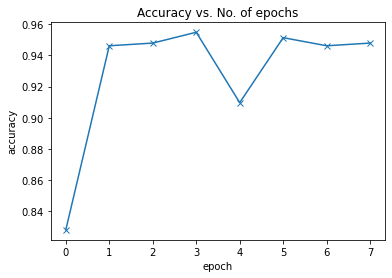

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

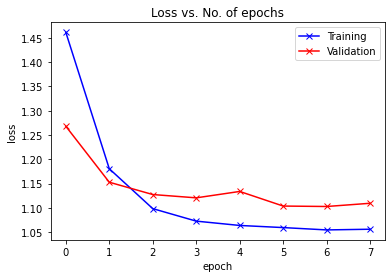

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


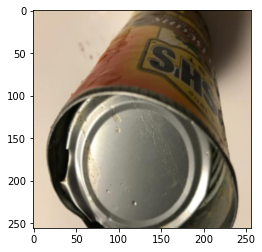

In [27]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


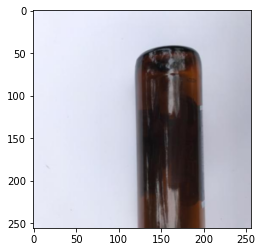

In [28]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


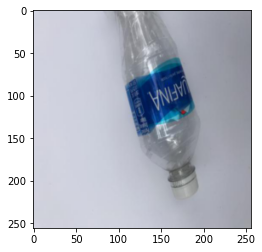

In [29]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


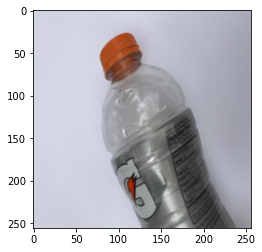

In [30]:
img, label = test_ds[4]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: metal , Predicted: glass


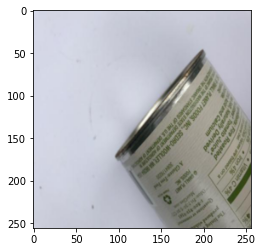

In [31]:
img, label = test_ds[19]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


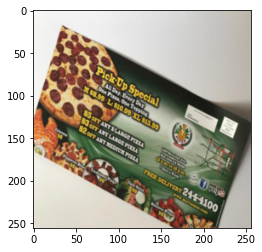

In [32]:
img, label = test_ds[5]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

In [33]:
import urllib.request
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fengage.vic.gov.au%2Fapplication%2Ffiles%2F1415%2F0596%2F9236%2FDSC_0026.JPG&f=1&nofb=1", "plastic.jpg")

urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fi.ebayimg.com%2Fimages%2Fi%2F291536274730-0-1%2Fs-l1000.jpg&f=1&nofb=1", "cardboard.jpg")    

urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", "cans.jpg") 

urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftinytrashcan.com%2Fwp-content%2Fuploads%2F2018%2F08%2Ftiny-trash-can-bulk-wine-bottle.jpg&f=1&nofb=1", "wine-trash.jpg")

urllib.request.urlretrieve("http://ourauckland.aucklandcouncil.govt.nz/media/7418/38-94320.jpg", "paper-trash.jpg")


('paper-trash.jpg', <http.client.HTTPMessage at 0x7f96928422d0>)

In [34]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [35]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles metal.


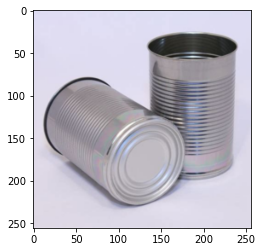

In [36]:
predict_external_image('cans.jpg')

The image resembles cardboard.


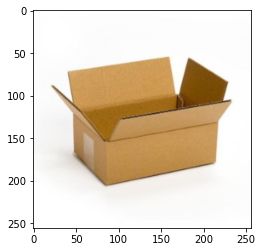

In [37]:
predict_external_image('cardboard.jpg')

The image resembles plastic.


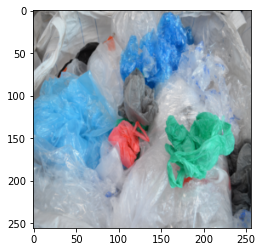

In [38]:
predict_external_image('plastic.jpg')

The image resembles glass.


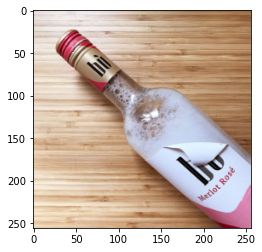

In [39]:
predict_external_image('wine-trash.jpg')

The image resembles paper.


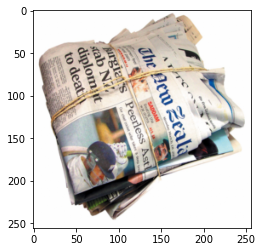

In [40]:
predict_external_image('paper-trash.jpg')